In [1]:
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")


# Define the parameters

delta_max = 0
Op_max = 0

SL = list()
profit = list()
Profit_sl = list()
Inventory_cost = list()
Incentive = list()

l=10
m=2
n=50
inc = 0.4
Op = 0.00
Op_new = 0.1
delta = -0.05
OV = 0
OV_new = -10000
g = 0.02

# create a 2D list with l rows and m columns filled with zeros
U0 = [[0 for j in range(m)] for i in range(l)]

R = [R_i for R_i in range(l)]
Alpha = [Alpha_i for Alpha_i in range(l)]
L = [L_j for L_j in range(m)]
S = [S_j for S_j in range(m)]
Q = [Q_j for Q_j in range(m)]
Beta = [Beta_k for Beta_k in range(n)]
D = [D_k for D_k in range(n)]
SD = [SD_k for SD_k in range(n)]
du = [[du_ij for du_ij in range(m)] for _ in range(l)]
dv = [[dv_jk for dv_jk in range(n)] for _ in range(m)]

# read data from CSV file
df = pd.read_csv('data.csv')

# Define the sets
A = range(l)
B = range(m)
C = range(n)

R = df['R'][0:l].tolist()
Alpha = df['Alpha'][0:l].tolist()
L = df['L'][0:m].tolist()
S = df['S'][0:m].tolist()
Q = df['q'][0:m].tolist()
Beta = df['Beta'][0:n].tolist()
D = df['D'][0:n].tolist()
SD = df['SD'][0:n].tolist()
du = df['du'][0:l*m].tolist()
dv = df['dv'][0:m*n].tolist()

while(delta <= 1.8):
    # Define the decision variables
    u = {(i,j): LpVariable(f"u({i},{j})", lowBound=0) for i in A for j in B}
    v = {(j,k): LpVariable(f"v({j},{k})", lowBound=0) for j in B for k in C}


    # Define the optimization problem
    prob = LpProblem("Supply Chain Optimization", LpMaximize)

    delta += 0.05
    # Define the constraints
    for i in A:
        prob += sum(u[i,j] for j in B) <= R[i]

    for j in B:
        prob += Q[j] + sum(u[i,j] for i in A) - sum(v[j,k] for k in C) >= 0
        prob += Q[j] + sum(u[i,j] for i in A) - sum(v[j,k] for k in C) <= L[j]
        prob += sum((Q[j] + sum(u[i,j] for i in A)) for j in B) >= sum((D[k]+delta*SD[k]) for k in C)

    for k in C:
        prob += sum(v[j,k] for j in B) == D[k]

    procurement_cost = sum(Alpha[i] * sum(u[i,j] for j in B) for i in A)
    storage_cost = sum(S[j]*(Q[j] + sum(u[i,j] for i in A) - sum(v[j,k] for k in C)) for j in B)
    revenue = sum(Beta[k]*D[k] for k in C)
    transportation_cost = g*((sum(du[m*i+j]*u[i,j] for i in A for j in B)) + (sum(dv[n*j+k]*v[j,k] for j in B for k in C)))

    # Set the objective function
    prob += revenue - transportation_cost - procurement_cost - storage_cost

    # Solve the problem
    prob.solve()
    
    if(LpStatus[prob.status] != 'Optimal'):
        print(LpStatus[prob.status])
        break
   
    OV = OV_new
    OV_new = value(prob.objective)
    sl = (math.erf(delta/math.sqrt(2))+1)/2
    Op_prev = Op
    Op = Op_new
    Op_new = value(prob.objective)*(1 + inc*sl**2)
    
    if(Op_new>Op_max):
        Op_max = Op_new
        delta_max = delta
            
        for i in range(l):
            for j in range(m):
                U0[i][j]=u[i,j].value()                
    
    profit.append(OV_new)
    SL.append(sl)
    Profit_sl.append(Op_new)
    Inventory_cost.append(value(storage_cost)/10000)
    Incentive.append(value(prob.objective)*inc*sl**2)
    
    #print('service level = ', 50*(math.erf(delta/math.sqrt(2))+1), '%')
    #print("tc", value(transportation_cost)/1000)
    #print("stc", value(storage_cost)/1000)
    #print('stored value at 1 :', value(Q[1] + sum(u[i,1] for i in A) - sum(v[1,k] for k in C)))
    #print("Op for delta = ", delta, ' : ', Op_new/10000, "\n")1
    
    

# Print the problem statement
# print(prob)

# Print the results
# print("Status:", LpStatus[prob.status])
print("Optimal Solution:")
#for var in prob.variables():
    #print(var.name, "=", var.varValue)
print("Total Profit = ", Op_max)

print('optimal service level = ', 50*(math.erf((delta_max)/math.sqrt(2))+1), '%')

Optimal Solution:
Total Profit =  41014357.13117129
optimal service level =  89.43502263331449 %


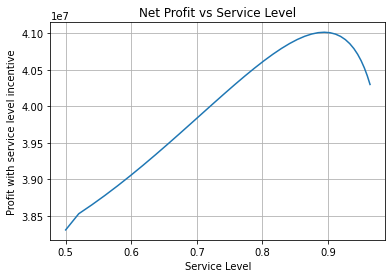

In [5]:
plt.plot(SL, Profit_sl)
plt.ylabel('Profit with service level incentive')
plt.xlabel('Service Level')
plt.title('Net Profit vs Service Level')
plt.grid(True)
plt.show()

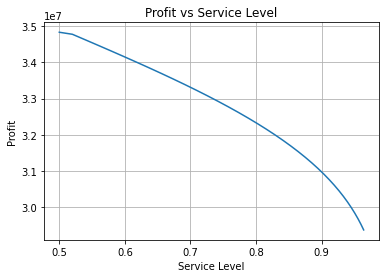

In [6]:
plt.plot(SL, profit)
plt.ylabel('Profit')
plt.xlabel('Service Level')
plt.title('Profit vs Service Level')
plt.grid(True)
plt.show()

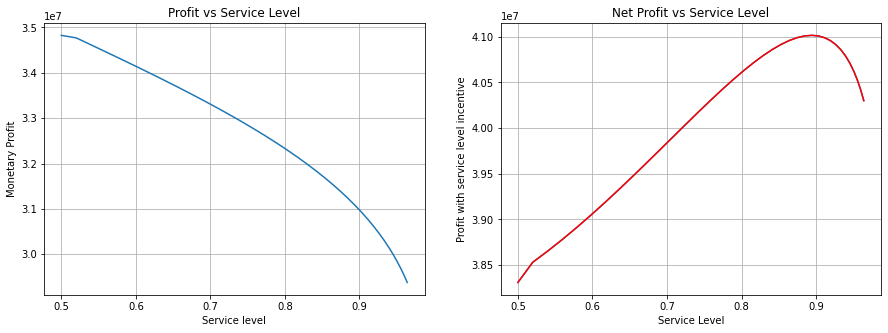

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(SL, profit)
axs[0].set_xlabel('Service level')
axs[0].set_ylabel('Monetary Profit')
axs[0].set_title('Profit vs Service Level')
axs[0].grid(True)

axs[1].plot(SL, Profit_sl)
axs[1].set_ylabel('Profit with service level incentive')
axs[1].set_xlabel('Service Level')
axs[1].set_title('Net Profit vs Service Level')
axs[1].grid(True)
axs[1].plot(SL, Profit_sl, color='red')
fig.suptitle('', fontsize=16)

plt.show()


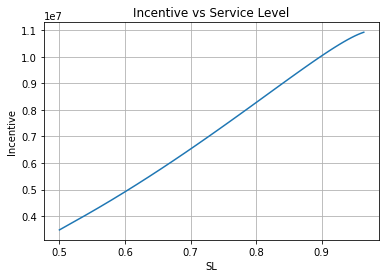

In [8]:
plt.plot(SL, Incentive)
plt.ylabel('Incentive')
plt.xlabel('SL')
plt.title('Incentive vs Service Level')
plt.grid(True)
plt.show()

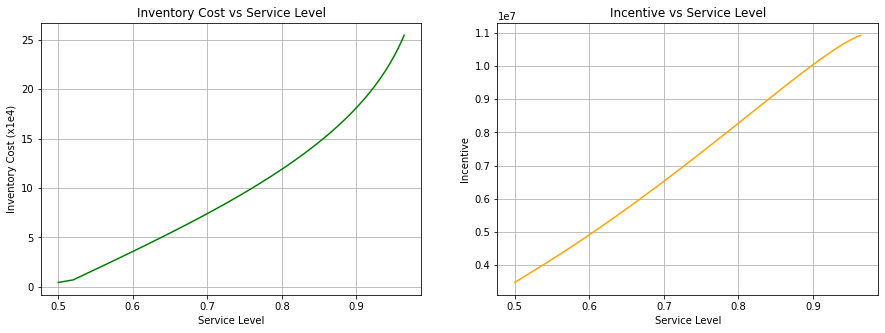

In [9]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(SL, Inventory_cost, color='green')
ax1.set_ylabel('Inventory Cost (x1e4)')
ax1.set_xlabel('Service Level')
ax1.set_title('Inventory Cost vs Service Level')
ax1.grid(True)

ax2.plot(SL, Incentive, color='orange')
ax2.set_ylabel('Incentive')
ax2.set_xlabel('Service Level')
ax2.set_title('Incentive vs Service Level')
ax2.grid(True)

plt.show()



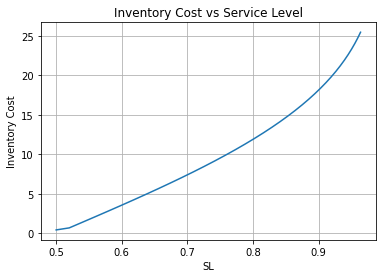

In [10]:
plt.plot(SL, Inventory_cost)
plt.ylabel('Inventory Cost')
plt.xlabel('SL')
plt.title('Inventory Cost vs Service Level')
plt.grid(True)
plt.show()

In [11]:
# Define the decision variables
u_ = {(i,j): LpVariable(f"u({i},{j})", lowBound=0) for i in A for j in B}
v_ = {(j,k): LpVariable(f"v({j},{k})", lowBound=0) for j in B for k in C}

# Define the optimization problem
prob2 = LpProblem("Supply_Chain_Optimization", LpMaximize)

# Define the constraints
for i in A:
    prob2 += sum(u_[i,j] for j in B) <= R[i]

for j in B:
    prob2 += Q[j] + sum(u_[i,j] for i in A) - sum(v_[j,k] for k in C) >= 0
    prob2 += Q[j] + sum(u_[i,j] for i in A) - sum(v_[j,k] for k in C) <= L[j]
    prob2 += sum((Q[j] + sum(u_[i,j] for i in A)) for j in B) >= sum((D[k]+delta_max*SD[k]) for k in C)

for k in C:
    prob2 += sum(v_[j,k] for j in B) == D[k]+delta_max*SD[k]

procurement_cost_ = sum(Alpha[i] * sum(u_[i,j] for j in B) for i in A)
storage_cost_ = sum(S[j]*(Q[j] + sum(u_[i,j] for i in A) - sum(v_[j,k] for k in C)) for j in B)
revenue_ = sum(Beta[k]*(D[k]+delta_max*SD[k]) for k in C)
transportation_cost_ = g*((sum(du[m*i+j]*u_[i,j] for i in A for j in B)) + (sum(dv[n*j+k]*v_[j,k] for j in B for k in C)))

# Set the objective function
prob2.setObjective(revenue_ - transportation_cost_ - procurement_cost_ - storage_cost_)

# Solve the problem
prob2.solve()
    
U1 = [[0 for j in range(m)] for i in range(l)]

for i in range(l):
    for j in range(m):
        U1[i][j] = u_[i,j].value()

print(LpStatus[prob2.status])
print(value(storage_cost_))
print(value(prob2.objective))
print(np.array(U1))
print(np.array(U0))

Optimal
4500.000000000004
39757503.025000006
[[326400.      0.]
 [500000.      0.]
 [500000.      0.]
 [500000.      0.]
 [500000.      0.]
 [     0.      0.]
 [     0.      0.]
 [     0.      0.]
 [500000.      0.]
 [     0.      0.]]
[[317400.      0.]
 [155580. 344420.]
 [500000.      0.]
 [500000.      0.]
 [500000.      0.]
 [     0.      0.]
 [     0.      0.]
 [     0.      0.]
 [500000.      0.]
 [     0.      0.]]


In [12]:
h=-0.05
PD0 = list() # List to store the profits at varying demands
PD1 = list()
PD = [PD0, PD1]
H = list()  # List of values of 'h'
U = [U0, U1]
TC0 = list()
TC1 = list()
TC = [TC0, TC1]

for w in range(2):
    h=0
    while(h <= delta_max):
        prob1 = LpProblem("Supply Chain Optimization 1", LpMaximize)

        v1 = {(j,k): LpVariable(f"v({j},{k})", lowBound=0) for j in B for k in C}

        for j in B: 
            prob1 += Q[j] + sum(U[w][i][j] for i in A) - sum(v[j,k] for k in C) >= 0
            prob1 += Q[j] + sum(U[w][i][j] for i in A) - sum(v[j,k] for k in C) <= L[j]

        for k in C:
            prob1 += sum(v[j,k] for j in B) == D[k]+h*SD[k]

        procurement_cost1 = sum(Alpha[i] * sum(U[w][i][j] for j in B) for i in A)
        storage_cost1 = sum(S[j]*(Q[j] + sum(U[w][i][j] for i in A) - sum(v[j,k] for k in C)) for j in B)
        revenue1 = sum(Beta[k]*(D[k]+h*SD[k]) for k in C)
        transportation_cost1 = g*((sum(du[m*i+j]*U[w][i][j] for i in A for j in B)) + (sum(dv[n*j+k]*v[j,k] for j in B for k in C)))

        prob1 += revenue1 - transportation_cost1 - procurement_cost1 - storage_cost1

        prob1.solve()

        Op_D = value(prob1.objective)
        PD[w].append(Op_D)
        if(w==0):
            H.append(h)
        h+=0.05

        #print("Status:", LpStatus[prob1.status])
        #print(Op_D)
        if(LpStatus[prob1.status]=='Infeasible'):
            break

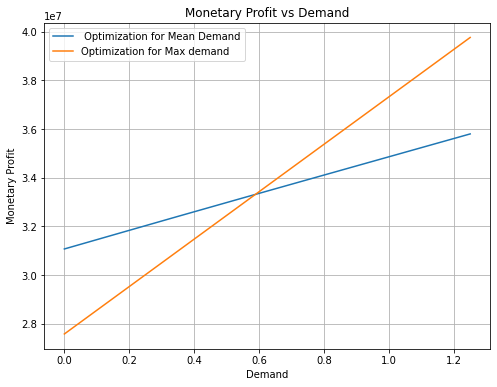

In [13]:
fig, (bx) = plt.subplots(1, figsize=(8, 6))

bx.plot(H, PD0, label=' Optimization for Mean Demand')
bx.plot(H, PD1, label='Optimization for Max demand')
bx.set_ylabel('Monetary Profit')
bx.set_xlabel('Demand')
bx.set_title('Monetary Profit vs Demand')
bx.legend()
bx.grid(True)

plt.show()

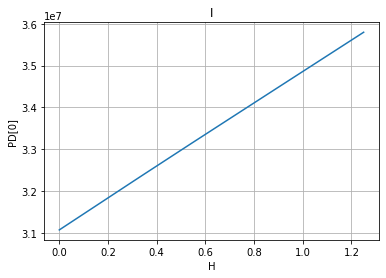

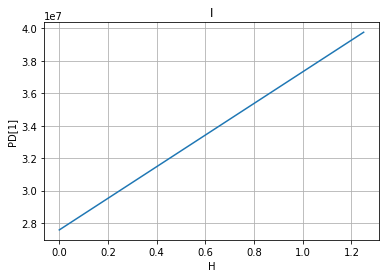

In [14]:
plt.plot(H, PD[0])
plt.ylabel('PD[0]')
plt.xlabel('H')
plt.title('I')
plt.grid(True)
plt.show()

plt.plot(H, PD[1])
plt.ylabel('PD[1]')
plt.xlabel('H')
plt.title('I')
plt.grid(True)
plt.show()